In [1]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt


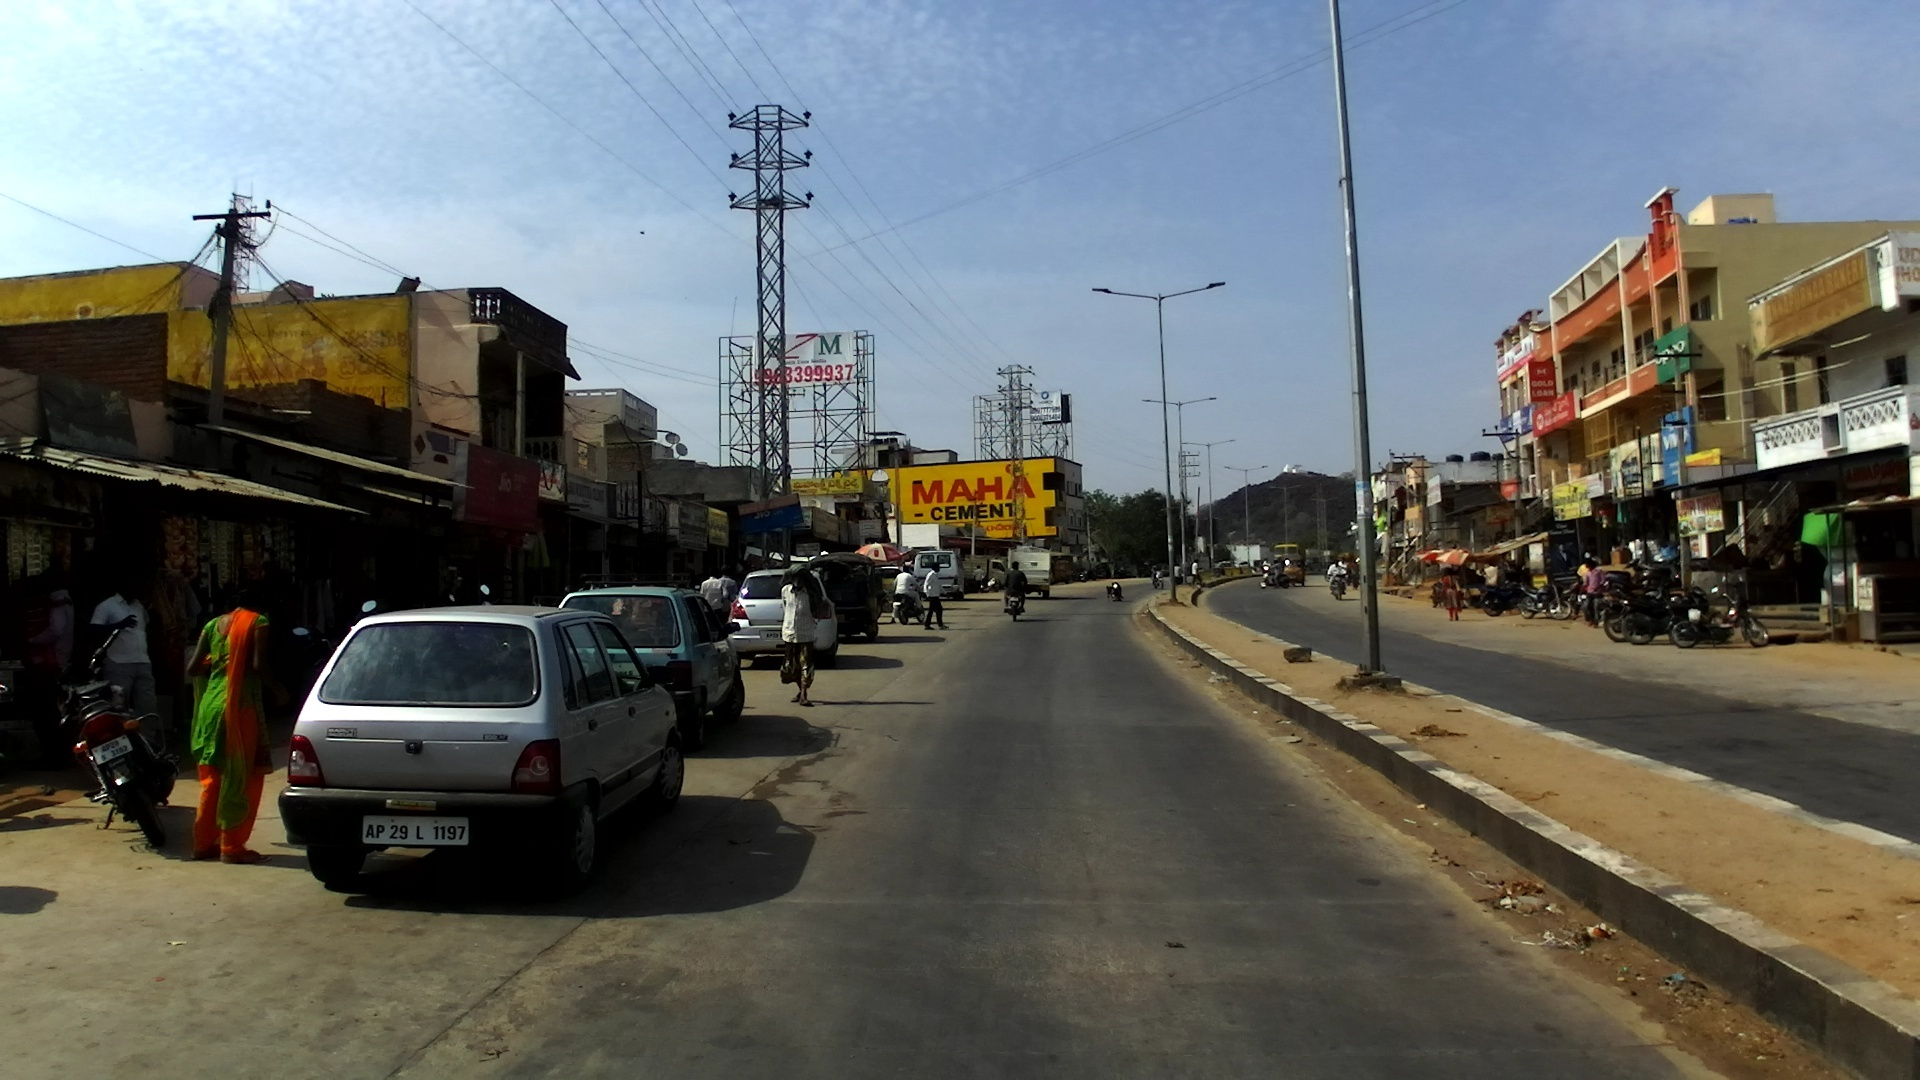

In [2]:
# Plot the image
def imshow(img, ax=None):
	if ax is None:
		ret, encoded = cv2.imencode(".jpg", img)
		display(Image(encoded))
	else:
		ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
		ax.axis('off')

#Image loading
img = cv2.imread(r'E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\train\201\frame0029_leftImg8bit.jpg')
# Show image
imshow(img)


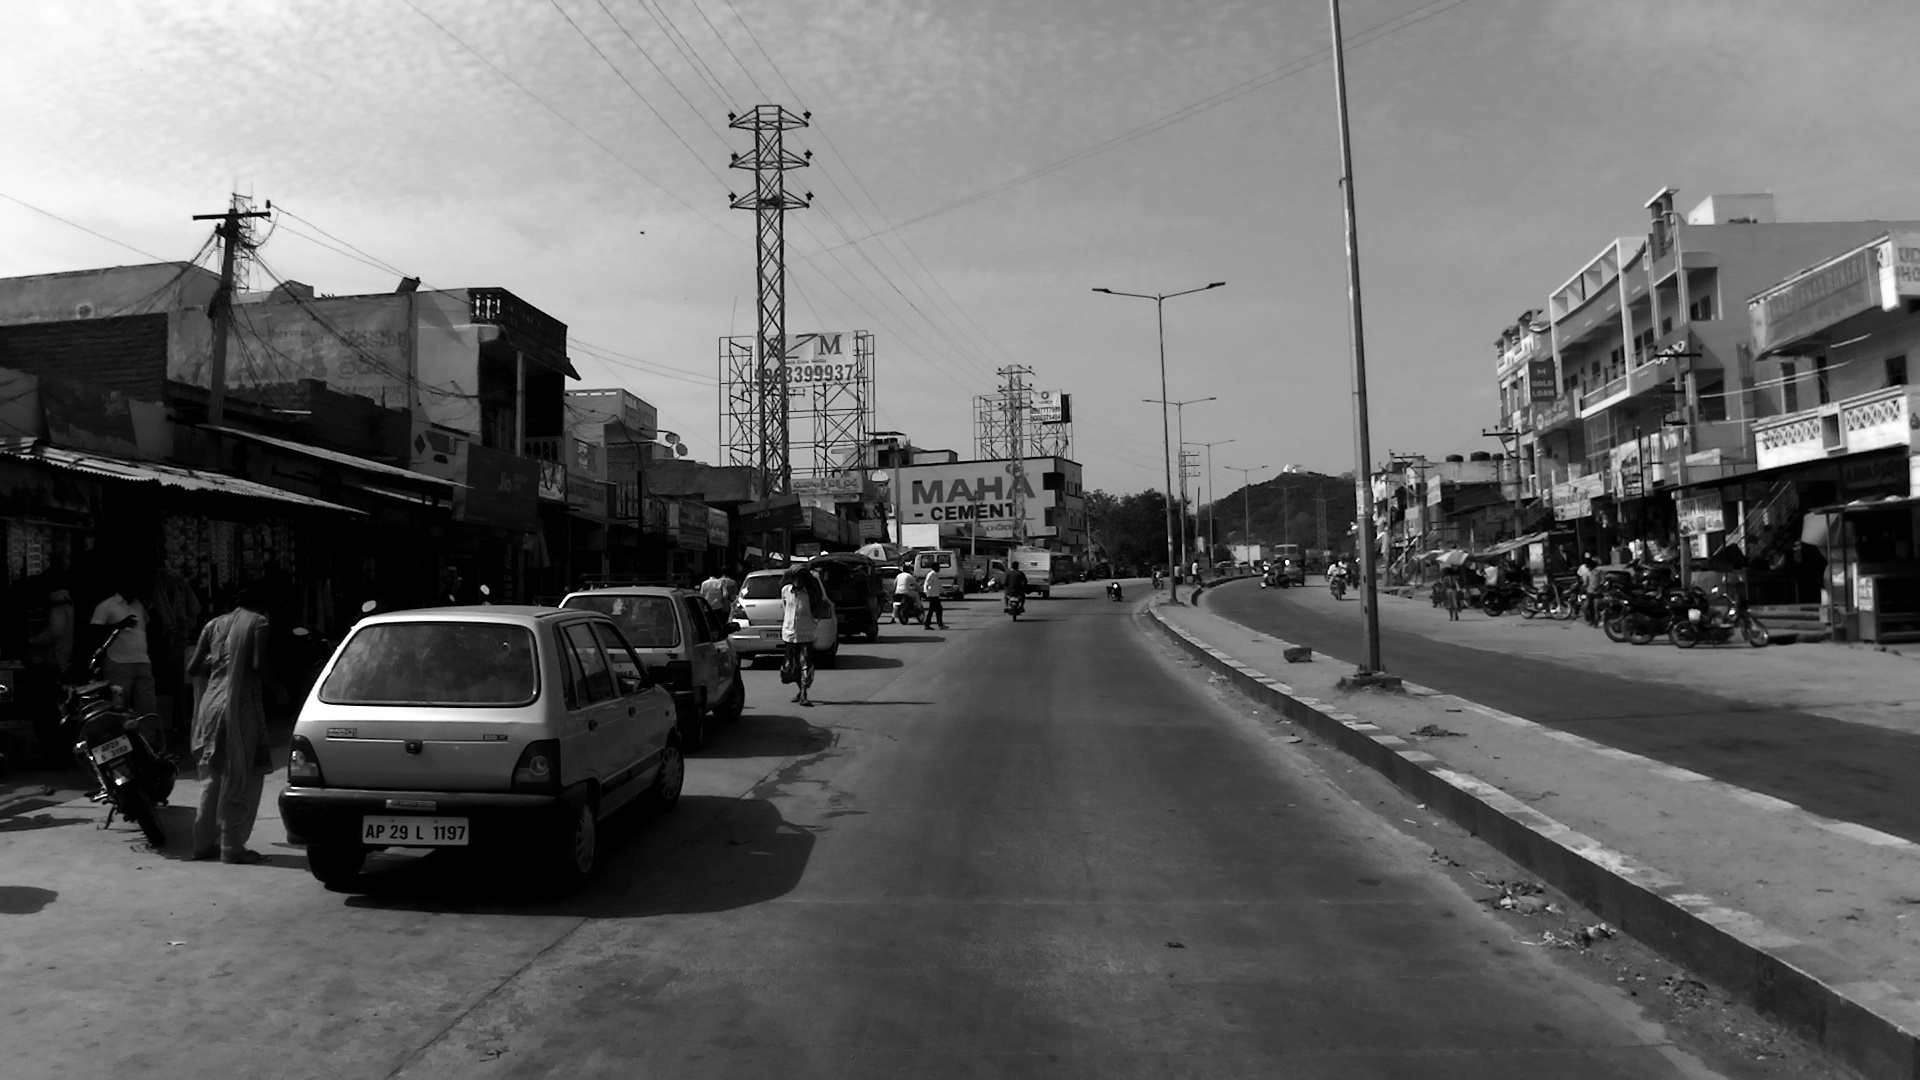

In [3]:
#image grayscale conversion
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)


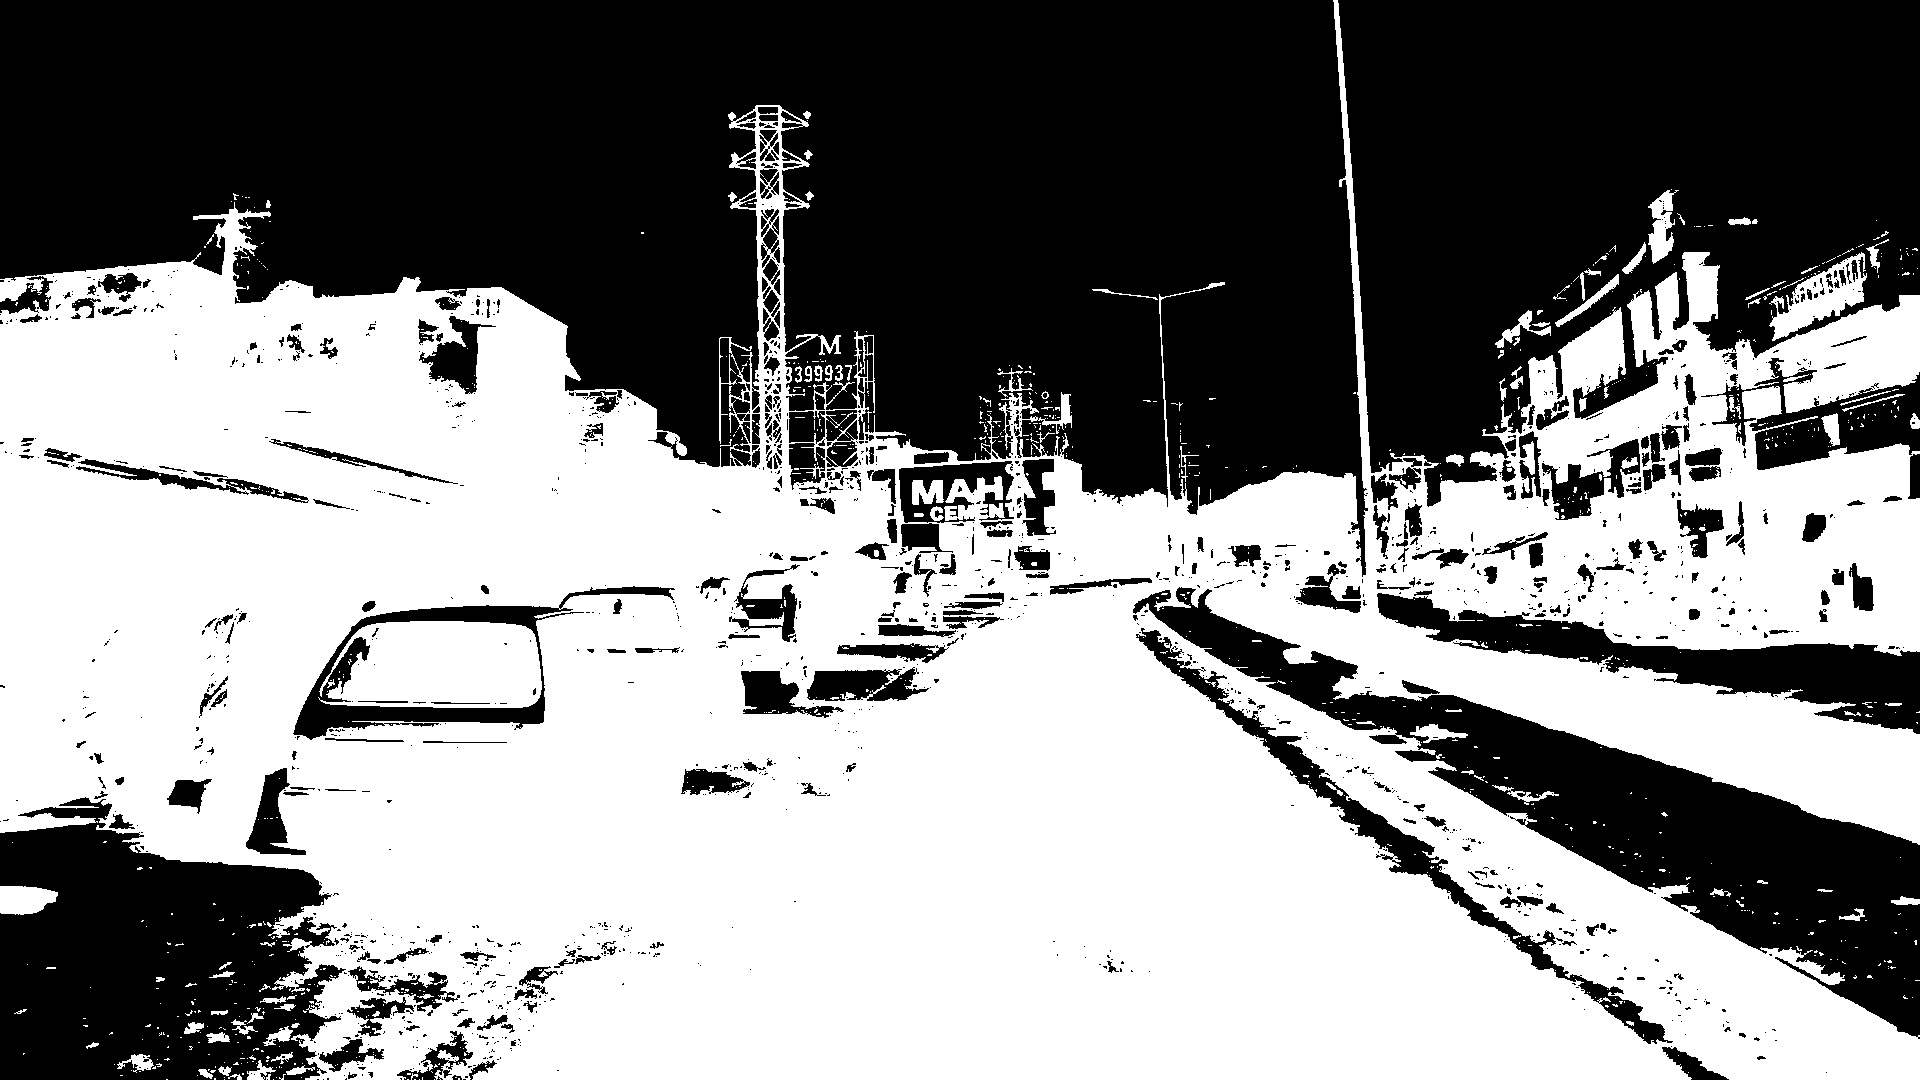

In [4]:
#Threshold Processing
ret, bin_img = cv2.threshold(gray,
							0, 255, 
							cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
imshow(bin_img)


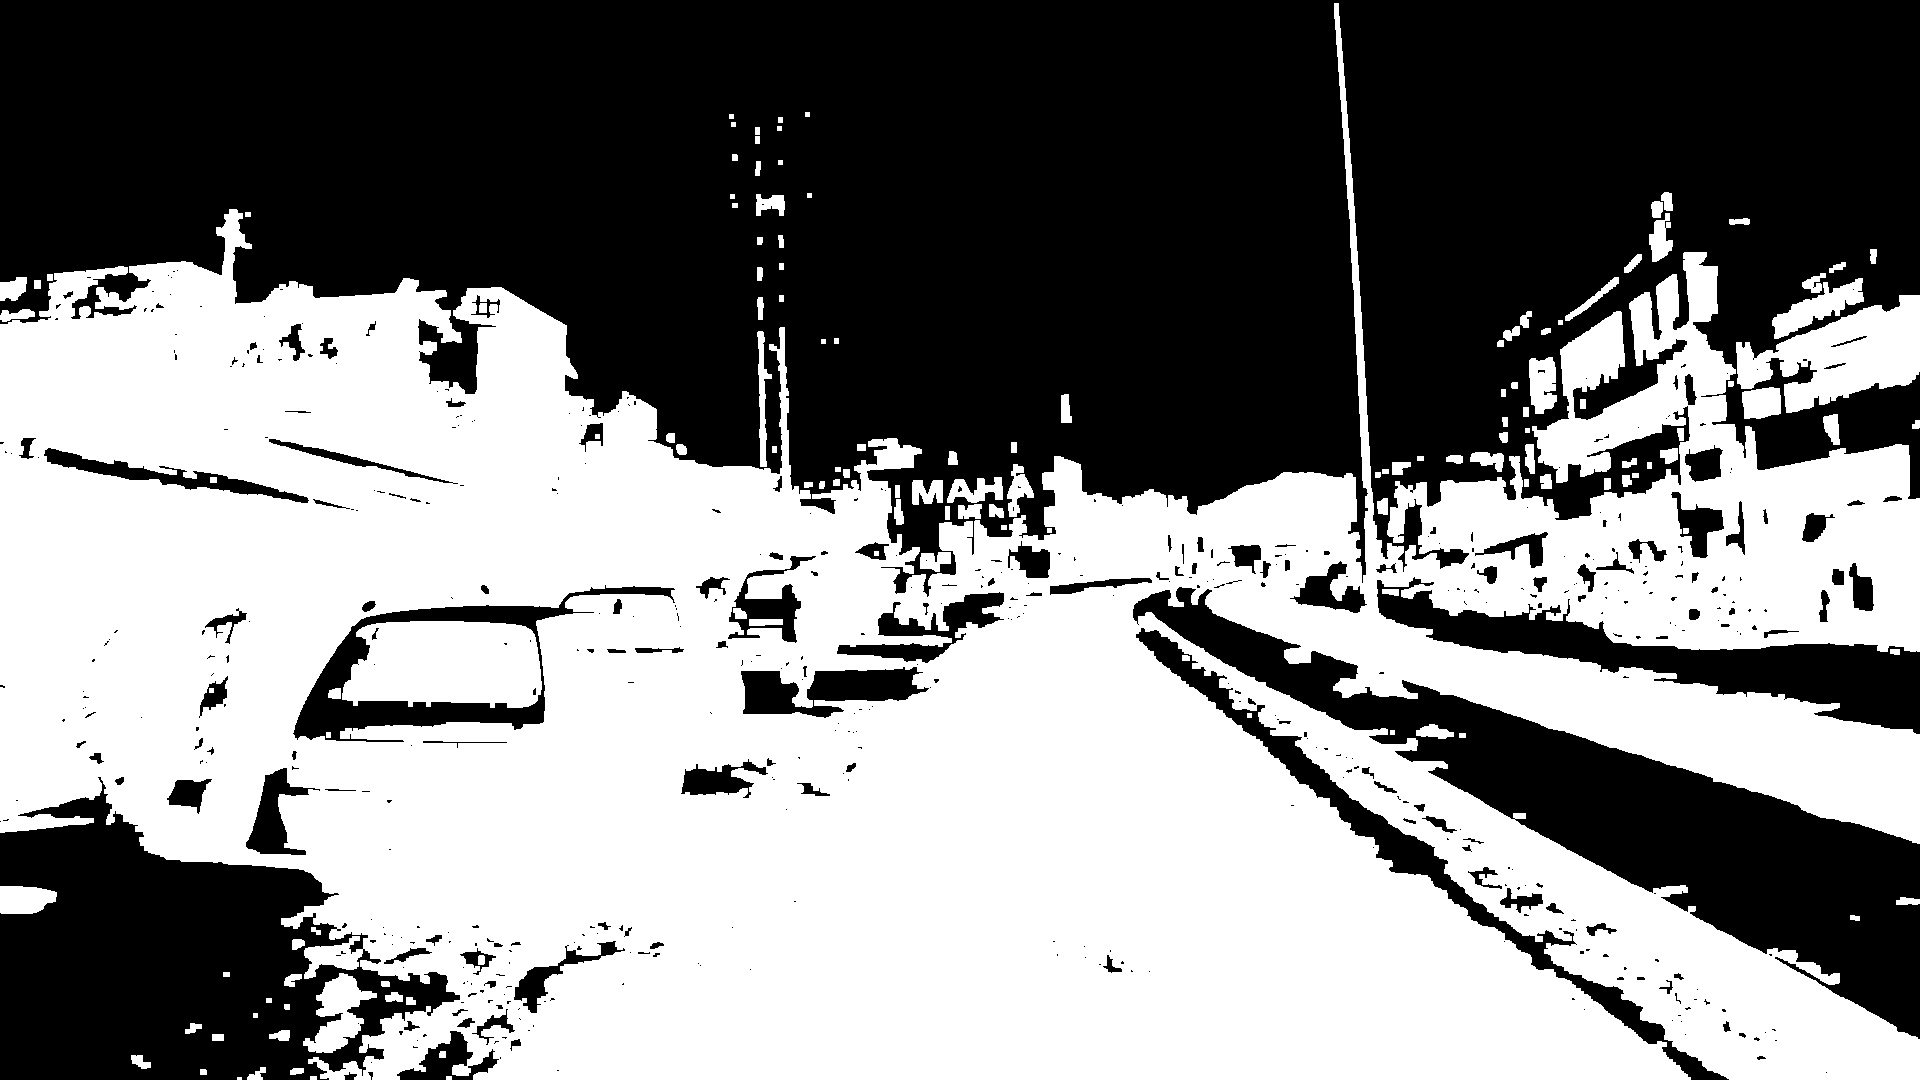

In [5]:
# noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, 
						cv2.MORPH_OPEN,
						kernel,
						iterations=2)
imshow(bin_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..210.96727].


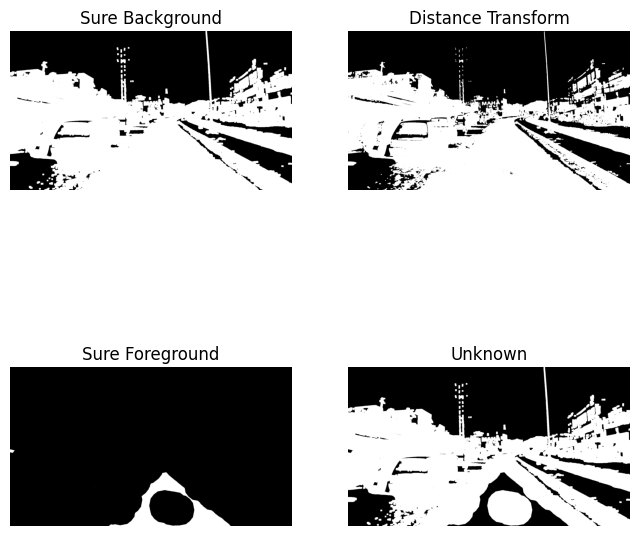

In [6]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')

# Distance transform
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')

#foreground area
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8) 
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')

# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')

plt.show()


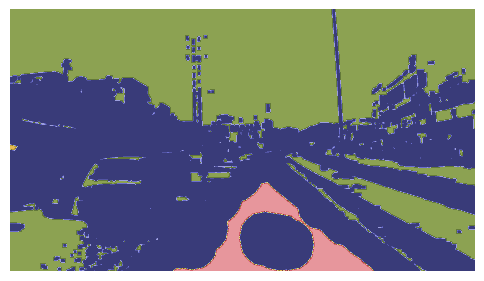

In [7]:
# Marker labelling
# sure foreground 
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


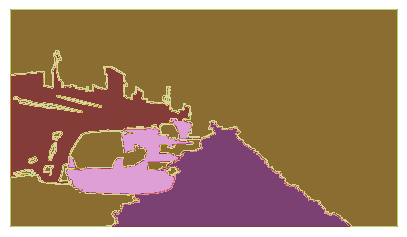

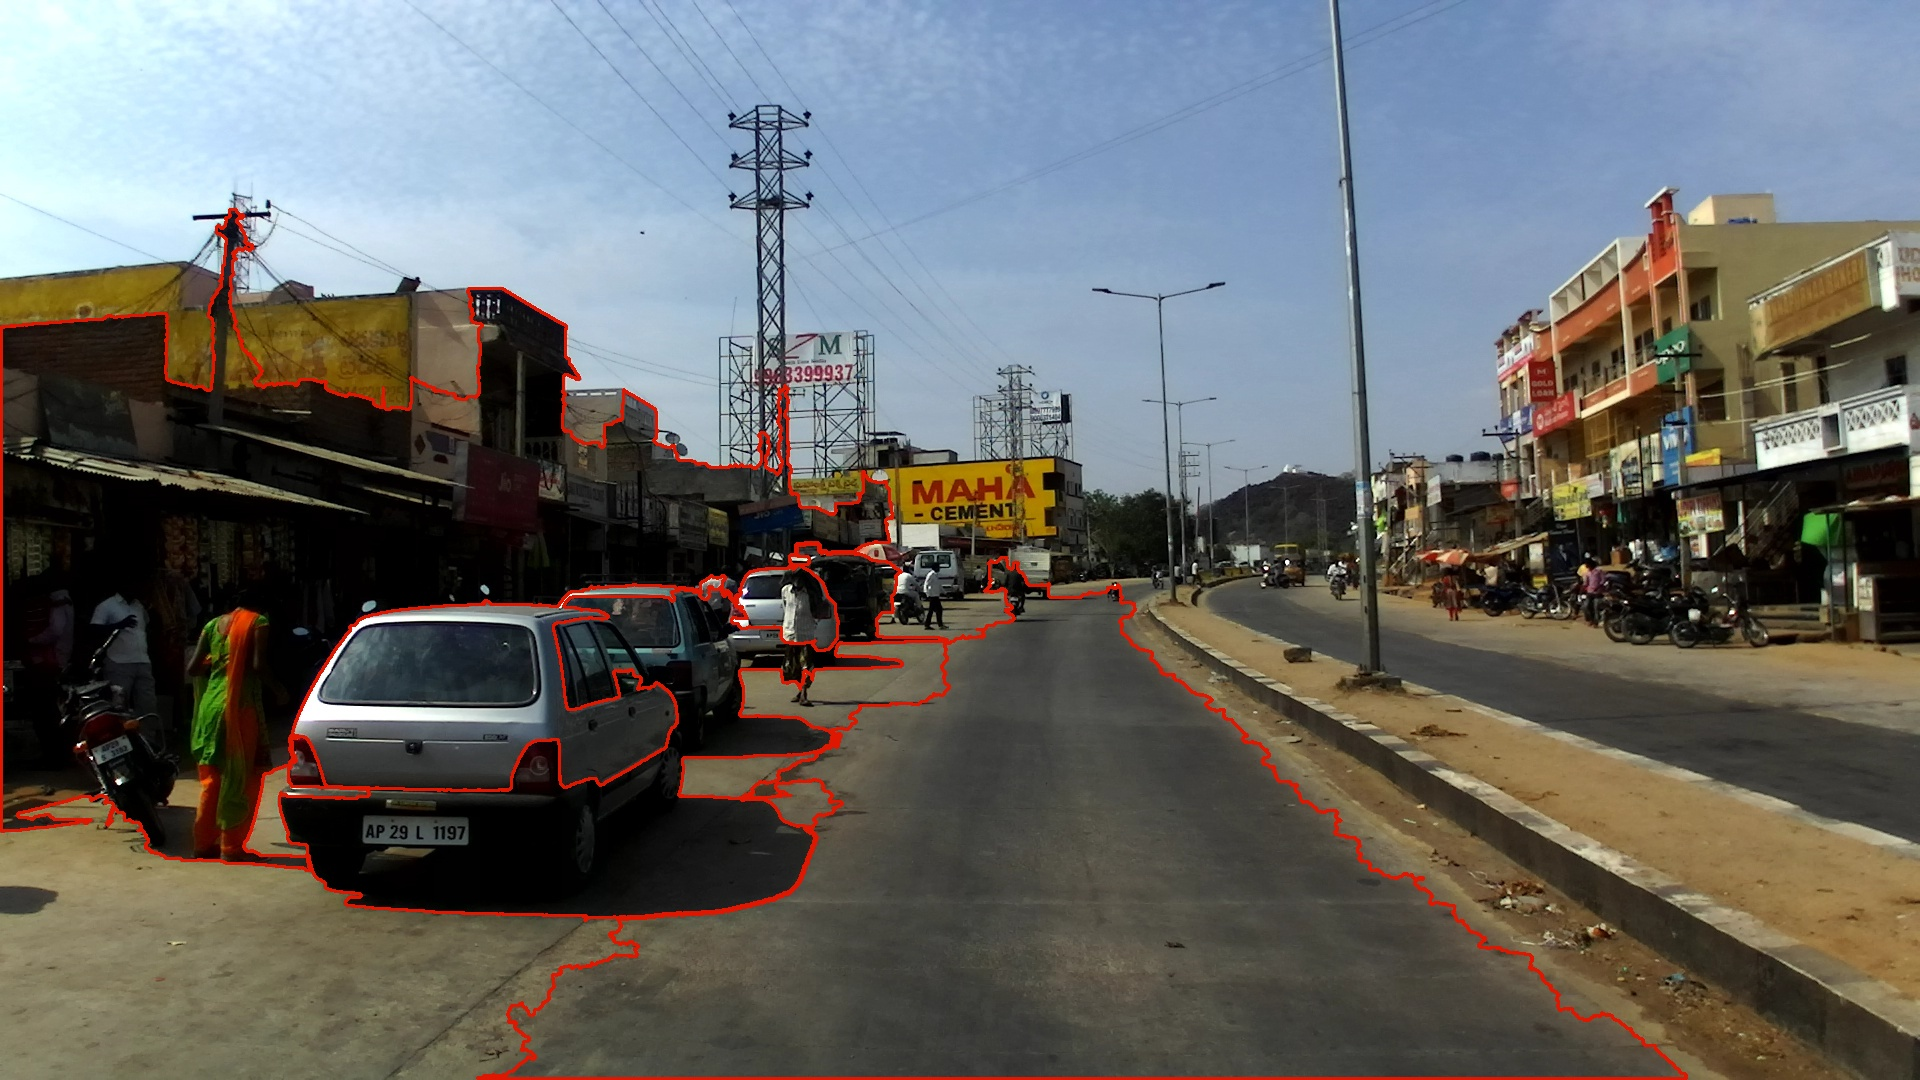

In [8]:
# watershed Algorithm
markers = cv2.watershed(img, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


labels = np.unique(markers)

coins = []
for label in labels[2:]: 

# Create a binary image in which only the area of the label is in the foreground 
#and the rest of the image is in the background 
	target = np.where(markers == label, 255, 0).astype(np.uint8)

# Perform contour extraction on the created binary image
	contours, hierarchy = cv2.findContours(
		target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
	)
	coins.append(contours[0])

# Draw the outline
img = cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=2)
imshow(img)


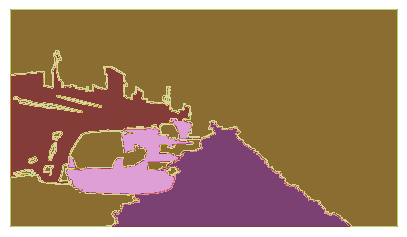

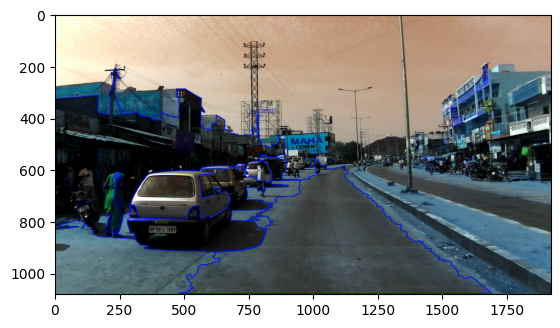

IoU for the road class: 0.3806837134564795


In [ ]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

with open(r'E:\Projects\Finished\Semantic Segmentation\idd20kII\gtFine\train\201\frame0029_gtFine_polygons.json', 'r') as file:
    data = json.load(file)

road_polygon = None
for obj in data['objects']:
    if obj['label'] == 'road':
        road_polygon = np.array(obj['polygon'], dtype=np.int32)
        break

road_mask = np.zeros((data['imgHeight'], data['imgWidth']), dtype=np.uint8)
cv2.fillPoly(road_mask, [road_polygon], 255)

markers = cv2.watershed(img, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

labels = np.unique(markers)

coins = []
for label in labels[2:]:
    target = np.where(markers == label, 255, 0).astype(np.uint8)

    contours, hierarchy = cv2.findContours(
        target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    coins.append(contours[0])
img = cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=2)
plt.imshow(img)
plt.show()

watershed_mask = np.zeros_like(markers, dtype=np.uint8)
for label in labels[2:]:
    watershed_mask[markers == label] = 255

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

iou = calculate_iou(road_mask, watershed_mask)
print(f"IoU for the road class: {iou}")

In [32]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def process_image_and_json(image_path, json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)

    road_polygon = None
    for obj in data['objects']:
        if obj['label'] == 'road':
            road_polygon = np.array(obj['polygon'], dtype=np.int32)
            break

    if road_polygon is None:
        return None

    road_mask = np.zeros((data['imgHeight'], data['imgWidth']), dtype=np.uint8)
    cv2.fillPoly(road_mask, [road_polygon], 255)

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Create markers for watershed
    markers = np.zeros_like(gray, dtype=np.int32)
    markers[binary == 255] = 1
    markers[binary == 0] = 2

    markers = cv2.watershed(img, markers)

    labels = np.unique(markers)
    watershed_mask = np.zeros_like(markers, dtype=np.uint8)
    for label in labels[2:]:
        watershed_mask[markers == label] = 255

    iou = calculate_iou(road_mask, watershed_mask)
    return iou

def process_directory(image_dir, json_dir):
    ious = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                json_path = os.path.join(json_dir, os.path.relpath(root, image_dir), file.replace('_leftImg8bit.jpg', '_gtFine_polygons.json'))
                print(image_path)
                print(json_path)
                if os.path.exists(json_path):
                    iou = process_image_and_json(image_path, json_path)
                    if iou is not None:
                        ious.append(iou)
    return ious

val_image_dir = r'E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\val'
val_json_dir = r'E:\Projects\Finished\Semantic Segmentation\idd20kII\gtFine\val'

val_ious = process_directory(val_image_dir, val_json_dir)

all_ious = val_ious
mean_iou = np.mean(all_ious)
print(f"Mean IoU for the road class: {mean_iou}")

E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\val\205\frame0340_leftImg8bit.jpg
E:\Projects\Finished\Semantic Segmentation\idd20kII\gtFine\val\205\frame0340_gtFine_polygons.json


E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\val\205\frame0671_leftImg8bit.jpg
E:\Projects\Finished\Semantic Segmentation\idd20kII\gtFine\val\205\frame0671_gtFine_polygons.json
E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\val\205\frame0821_leftImg8bit.jpg
E:\Projects\Finished\Semantic Segmentation\idd20kII\gtFine\val\205\frame0821_gtFine_polygons.json
E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\val\205\frame1047_leftImg8bit.jpg
E:\Projects\Finished\Semantic Segmentation\idd20kII\gtFine\val\205\frame1047_gtFine_polygons.json
E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\val\205\frame1347_leftImg8bit.jpg
E:\Projects\Finished\Semantic Segmentation\idd20kII\gtFine\val\205\frame1347_gtFine_polygons.json
E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\val\205\frame1527_leftImg8bit.jpg
E:\Projects\Finished\Semantic Segmentation\idd20kII\gtFine\val\205\frame1527_gtFine_polygons.json
E:\Projects\Finished